In [ ]:
import os
import time
import copy
import torch
import torch.optim
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score 
import torchvision.models as models
!pip install livelossplot --quiet
from livelossplot import PlotLosses
from torch.optim import lr_scheduler
from PIL import Image
from matplotlib import text
import matplotlib.pyplot as plt
from skimage import io, transform
import torchvision.models as models
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

     |████████████████████████████████| 1.6 MB 19.6 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#directory contains images
PATH = '/content/drive/Shareddrives/COMP576/dataset/Images'

# train-validation-test ratio
TRAIN = 0.7
VALID = 0.2
TEST = 0.1

# model parameters
size = 224
batch_size = 32
n_epochs = 20
step_size = 50

In [ ]:
data = pd.read_csv("/content/drive/Shareddrives/COMP576/dataset/filename.csv")

In [ ]:
data.head()

,filename,trueLabel
0,Black Sea Sprat0000.png,Black Sea Sprat
1,Black Sea Sprat0001.png,Black Sea Sprat
2,Black Sea Sprat0002.png,Black Sea Sprat
3,Black Sea Sprat0003.png,Black Sea Sprat
4,Black Sea Sprat0004.png,Black Sea Sprat


In [ ]:
def sample_split(data):
  """
  split the data into train, validation, test set
  """
  totNum = len(data)
  trainNum = int(TRAIN * totNum)
  validNum = int(VALID * totNum)

  train_set = data.sample(n=trainNum, ignore_index=False)
  rest_data = data.drop(train_set.index)
  valid_set = rest_data.sample(n=validNum, ignore_index=False)
  test_set = rest_data.drop(valid_set.index)
  
  return train_set, valid_set, test_set

In [ ]:
class FishDataset(Dataset):

    """Fish dataset."""

    def __init__(self, pdframe, root_dir, transform=None):
        self.fish_frame = pdframe
        self.root_dir = root_dir
        self.transform = transform
        self.categories = ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel',
                  'Red Mullet', 'Red Sea Bream', 'Sea Bass',
                  'Shrimp', 'Striped Red Mullet', 'Trout']
        self.categories2ids = {category: id for (id, category) 
                               in enumerate(self.categories)}
                               

    def __len__(self):
        return len(self.fish_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.fish_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        fish_species = self.fish_frame.iloc[idx, 1]
        label_id = self.categories2ids[fish_species]
        

        if self.transform:
            image = self.transform(image)
            
        return image, label_id

In [ ]:
data_transforms = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(), # data augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
train_set, valid_set, test_set = sample_split(data)
dataset_sizes = {"train": len(train_set), "val": len(valid_set)}
training = FishDataset(train_set, root_dir=PATH, transform=data_transforms)
validation = FishDataset(valid_set, root_dir=PATH, transform=data_transforms)

train_loader = torch.utils.data.  (training, 
                      batch_size = batch_size, 
                      shuffle = True, 
                      pin_memory = True,
                      num_workers = 2)

val_loader = torch.utils.data.DataLoader(validation, 
                     batch_size = batch_size, 
                     shuffle = False)



dataloaders = {"train": train_loader, "val": val_loader}

# Hyperparameter Tuning

In [ ]:
!pip install optuna

In [ ]:
import optuna
from optuna.trial import TrialState

In [ ]:
def createModel():
  model = models.resnet18(pretrained=False)
  in_features = model.fc.in_features
  model.fc = torch.nn.Linear(in_features, 9)
  return model

In [ ]:
def objective(trial):
  model = createModel()
  cost_function = torch.nn.CrossEntropyLoss()
  learningRate = trial.suggest_float(name="learningRate", low=1e-4, high=1e-1)
  gamma = trial.suggest_float(name="gamma", low=0.0001, high=0.2)
  optimizer = torch.optim.SGD(model.parameters(), lr = learningRate)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

  device = torch.device('cuda')
  model = model.to(device)
  cost_function = cost_function.to(device)
  
  best_acc = 0.0

  for epoch in range(n_epochs):
      print(f'Epoch {epoch}/{n_epochs - 1}')
      print('-' * 10)
      logs = {}

      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set training mode
          else:
              model.eval()   # Set evaluate mode

          running_loss = 0.0
          running_corrects = 0

          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = cost_function(outputs, labels)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)
          if phase == 'train' and scheduler != -1:
              scheduler.step()

          epoch_loss = running_loss / dataset_sizes[phase]
          epoch_acc = (running_corrects.double() / dataset_sizes[phase]).item()

          if phase == "train":
            logs["loss"] = epoch_loss
            logs["accuracy"] = epoch_acc
          else:
            logs['val_loss'] = epoch_loss
            logs['val_accuracy'] = epoch_acc              

          print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc

      # this will always return accuracy in validation set
      trial.report(epoch_acc, epoch) 
      # Handle pruning based on the intermediate value.
      if trial.should_prune():
          raise optuna.exceptions.TrialPruned()

  print(f'Best val Acc: {best_acc:4f}')
  return epoch_acc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=60*60*4)

In [ ]:
bst_trial = study.best_trial

print("Value:", bst_trial.value)

In [ ]:
for key, value in bst_trial.params.items():
    print("{}:{}".format(key, value))

# Train With Best Hyperparameter

In [ ]:
learningRate = 0.0098411
gamma = 0.01

In [ ]:
device = torch.device('cuda')

def train_model(batch_size, 
                n_epochs, 
                learningRate, 
                model, 
                dataset_sizes,
                cost_function, 
                optimizer,
                scheduler,
                dataloaders):
    # Move the model and cost function to GPU (if needed).
    model = model.to(device)
    cost_function = cost_function.to(device)
    
    liveloss = PlotLosses()

    since = time.time()

    # Keep track of best accuracy so far.
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(n_epochs):
        print(f'Epoch {epoch}/{n_epochs - 1}')
        print('-' * 10)
        logs = {}

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = cost_function(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train' and scheduler != -1:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = (running_corrects.double() / dataset_sizes[phase]).item()

            if phase == "train":
              logs["loss"] = epoch_loss
              logs["accuracy"] = epoch_acc
            else:
              logs['val_loss'] = epoch_loss
              logs['val_accuracy'] = epoch_acc              

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        liveloss.update(logs)
        liveloss.send()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

In [ ]:
resnet18 = models.resnet18(weights=False)
model = resnet18
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, 9)

cost_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learningRate, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

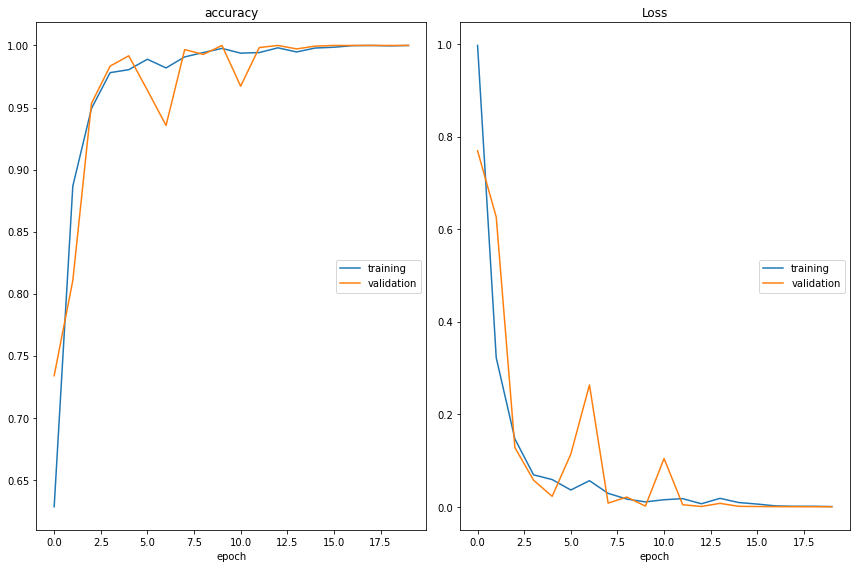

accuracy
	training         	 (min:    0.628, max:    1.000, cur:    1.000)
	validation       	 (min:    0.734, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.000, max:    0.997, cur:    0.000)
	validation       	 (min:    0.000, max:    0.769, cur:    0.000)
Training complete in 34m 14s
Best val Acc: 1.000000


NameError: ignored

In [ ]:
model, best_acc = train_model(batch_size, n_epochs, learningRate, 
                model, dataset_sizes, cost_function, optimizer, exp_lr_scheduler, 
                dataloaders);

# Output the weights with best accuracy in validation dataset

In [ ]:
torch.save(model.state_dict(), "/content/model_weights.pth")

In [ ]:
test_set.to_csv("test_data.csv", header=True, index=False)